In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

import sys
sys.path.append('../../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
# from RF_Utils import * 


# Load inhibition data 

In [2]:

split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/inhib'
train_x_df = pd.read_csv(split_path+"/inhib_train_x_normMorgan2.csv", header=None)
train_y_df= pd.read_csv(split_path+"/inhib_train_y_normMorgan2.csv", header=None)
test_x_df= pd.read_csv(split_path+"/inhib_test_x_normMorgan2.csv", header=None)
test_y_df= pd.read_csv(split_path+"/inhib_test_y_normMorgan2.csv", header=None)
train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape


((1635, 2048), (1635,), (409, 2048), (409,))

TRAIN: accuracy: 0.998, precision: 1.000, recall: 0.964, specificity: 1.000
TEST: accuracy: 0.956, precision: 0.708, recall: 0.607, specificity: 0.982


<Figure size 600x400 with 0 Axes>

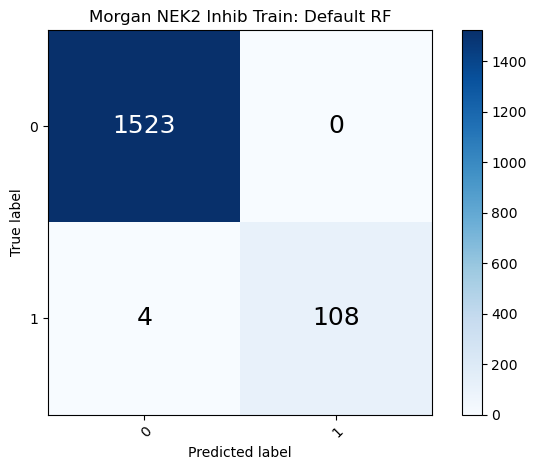

<Figure size 600x400 with 0 Axes>

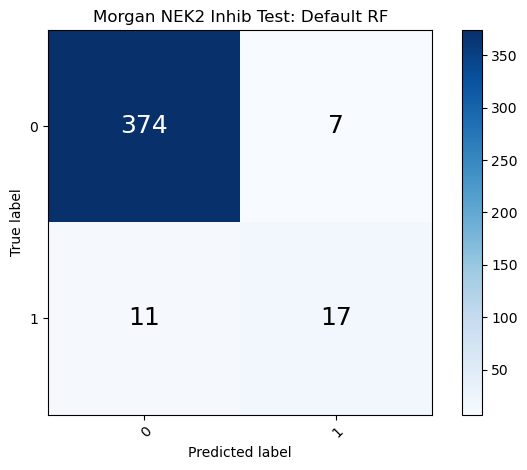

In [3]:
rf_basic100est = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {})
plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='Morgan NEK2 Inhib Train: Default RF')
plot_confusion_matrix(test_y, rf_basic100est['test_pred'], ['0','1'], title='Morgan NEK2 Inhib Test: Default RF')

In [15]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [9]:
# save_file = 'atom_nek2Morgan2inhib_rf_basic_best.pkl'
save_file = 'atom_nek2Morgan2inhib_rf_basic_grid.pkl'
# rf_basicbest = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid, 2)

In [10]:
save_file = 'atom_nek2Morgan2inhib_rf_basic_grid.pkl'
# with open(save_file, 'wb') as f:
#     pickle.dump(rf_basicbest['best_model'], f)

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


TRAIN: accuracy: 0.976, precision: 0.901, recall: 0.732,  specificity: 0.994
TEST: accuracy: 0.954, precision: 0.680, recall: 0.607, specificity: 0.979


<Figure size 600x400 with 0 Axes>

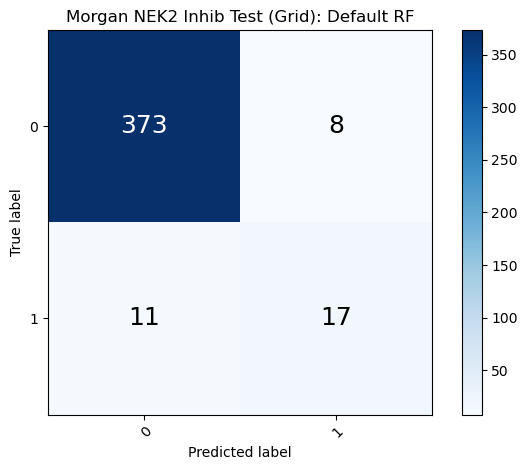

In [11]:
save_file = 'atom_nek2Morgan2inhib_rf_basic_grid.pkl'
with open('../saved_models/'+save_file, 'rb') as f: 
    rf_basicbest = pickle.load(f) 
grid_results = rf_results2(rf_basicbest, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results['test_pred'], ['0','1'], title='Morgan NEK2 Inhib Test (Grid): Default RF')


# Basic RF + classweight balanced 

TRAIN: accuracy: 0.998, precision: 0.966, recall: 1.000, specificity: 0.997
TEST: accuracy: 0.954, precision: 0.655, recall: 0.679, specificity: 0.974


<Figure size 600x400 with 0 Axes>

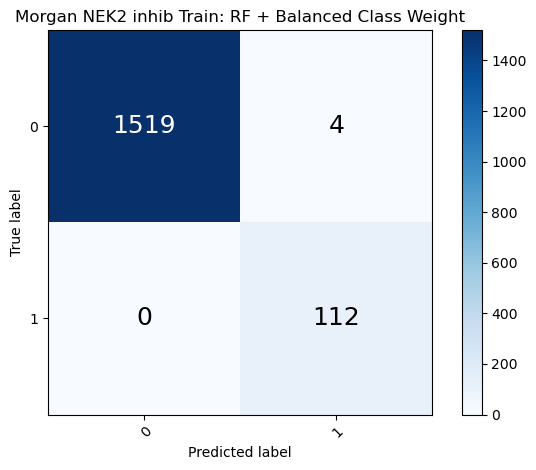

<Figure size 600x400 with 0 Axes>

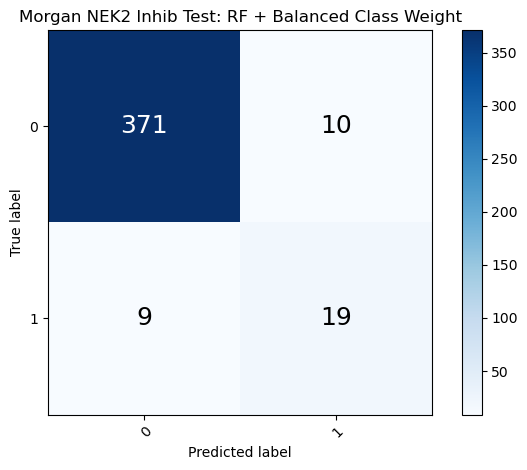

In [12]:
brf_model_BCW = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {})
plot_confusion_matrix(train_y, brf_model_BCW['train_pred'], ['0','1'], title='Morgan NEK2 inhib Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW['test_pred'], ['0','1'], title='Morgan NEK2 Inhib Test: RF + Balanced Class Weight')

TRAIN: accuracy: 0.924, precision: 0.364, recall: 0.143,  specificity: 0.982
TEST: accuracy: 0.922, precision: 0.357, recall: 0.179, specificity: 0.976


<Figure size 600x400 with 0 Axes>

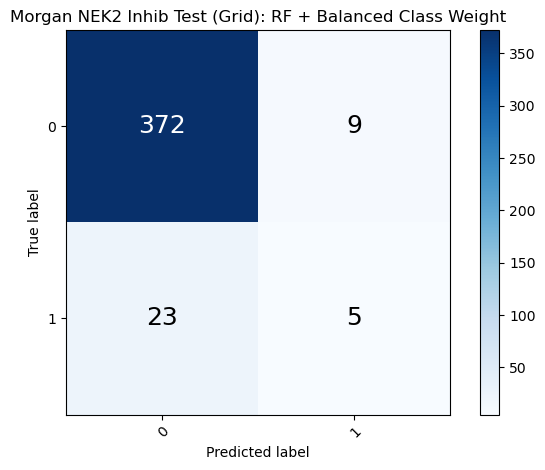

In [14]:
save_file2 = 'atom_nek2Morgan2inhib_rf_basicBCW_best.pkl'
# save_file2 = 'atom_nek2inhibMorgan2UNDER_rf_basicBCW_best.pkl'
# rf_basicBCWbest = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  2)
# started APr 27 10:47 pm
# with open(rf_basicBCWbest, 'wb') as f: 
#     pickle.dump(rf_basicBCWbest['best_model'], f)
    
with open('../saved_models/'+'atom_nek2bind_rf_basicBCW_grid_Morgan2.pkl', 'rb') as f: 
    rf_basicBCWbest = pickle.load(f) 
grid_results2 = rf_results2(rf_basicBCWbest, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results2['test_pred'], ['0','1'], title='Morgan NEK2 Inhib Test (Grid): RF + Balanced Class Weight')
# atom_nek2bindMorgan2_rf_basicBCW_best.pkl


# Balanced Random Forest Classifier

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.901, precision: 0.409, recall: 1.000, specificity: 0.894
TEST: accuracy: 0.888, precision: 0.350, recall: 0.750, specificity: 0.898


<Figure size 600x400 with 0 Axes>

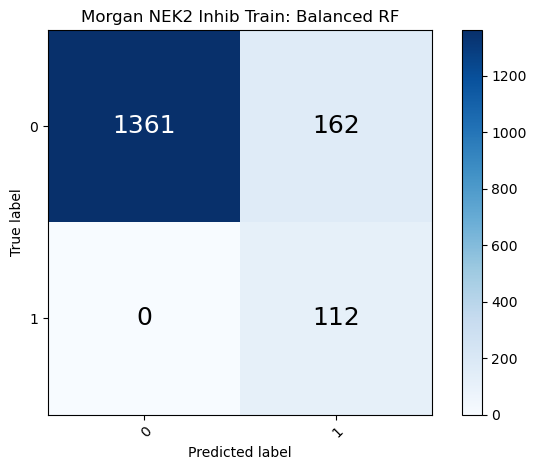

<Figure size 600x400 with 0 Axes>

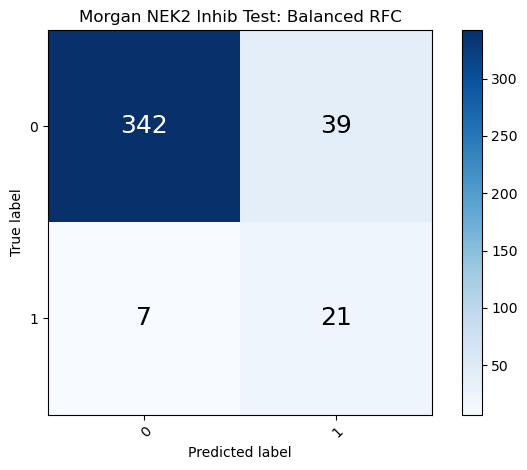

In [16]:
brf_model = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {})
plot_confusion_matrix(train_y, brf_model['train_pred'], ['0','1'], title='Morgan NEK2 Inhib Train: Balanced RF')
plot_confusion_matrix(test_y, brf_model['test_pred'], ['0','1'], title='Morgan NEK2 Inhib Test: Balanced RFC')

In [26]:
save_file3 = 'atom_nek2Morgan2inhib_BRFC_best.pkl'
# brfc_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {}, param_grid,  3, 2)
# started Apr 28 1:46 am 

/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to 

TRAIN: accuracy: 0.904, precision: 0.412, recall: 0.946, specificity: 0.901
TEST: accuracy: 0.900, precision: 0.377, recall: 0.714, specificity: 0.913


TRAIN: accuracy: 0.904, precision: 0.412, recall: 0.946,  specificity: 0.901
TEST: accuracy: 0.900, precision: 0.377, recall: 0.714, specificity: 0.913


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 600x400 with 0 Axes>

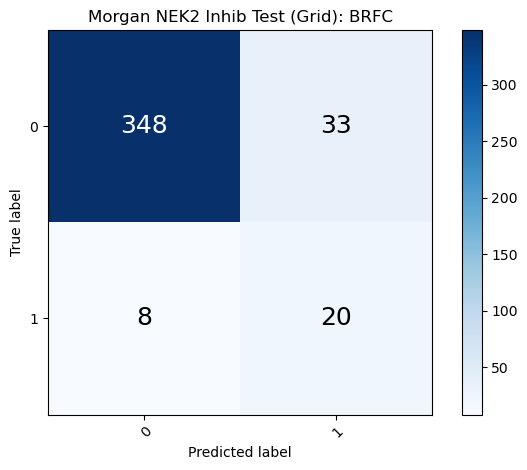

In [18]:
save_file3 = 'atom_nek2Morgan2inhib_BRFC_best.pkl'
# with open(save_file3, 'wb') as f:
#     pickle.dump(brfc_bestADASYN, f)

with open('../saved_models/'+save_file3, 'rb') as f: 
    brfc_best1 = pickle.load(f) 


grid_results3 = rf_results2(brfc_best1, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results3['test_pred'], ['0','1'], title='Morgan NEK2 Inhib Test (Grid): BRFC')


# Try BRFC with balanced class weight & bootstrap

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.731, precision: 0.203, recall: 1.000, specificity: 0.711
TEST: accuracy: 0.699, precision: 0.177, recall: 0.929, specificity: 0.682


<Figure size 600x400 with 0 Axes>

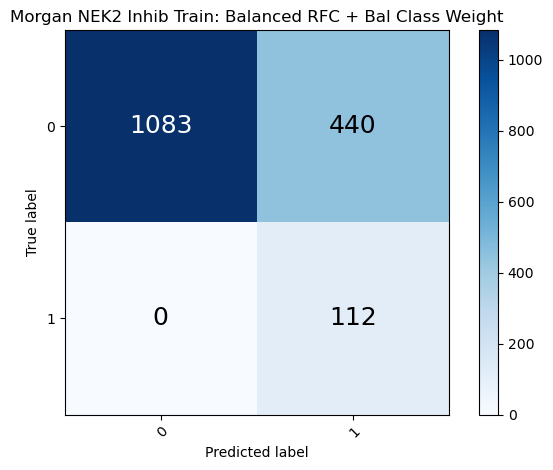

<Figure size 600x400 with 0 Axes>

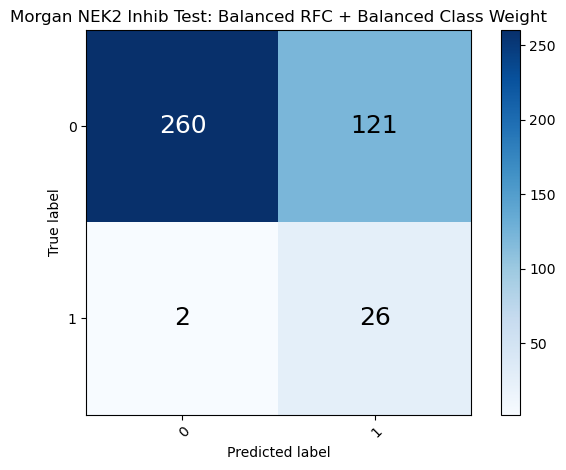

In [20]:
brf_modelCWB = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True})
plot_confusion_matrix(train_y, brf_modelCWB['train_pred'], ['0','1'], title='Morgan NEK2 Inhib Train: Balanced RFC + Bal Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB['test_pred'], ['0','1'], title='Morgan NEK2 Inhib Test: Balanced RFC + Balanced Class Weight')

In [21]:
save_file4 = 'atom_nek2Morgan2inhib_BRFC_BCW_best.pkl'
# brfc_BCW_ADASYN_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True}, param_grid,3)
# started Apr 28 1:20 am 

TRAIN: accuracy: 0.916, precision: 0.443, recall: 0.911,  specificity: 0.916
TEST: accuracy: 0.912, precision: 0.420, recall: 0.750, specificity: 0.924


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 600x400 with 0 Axes>

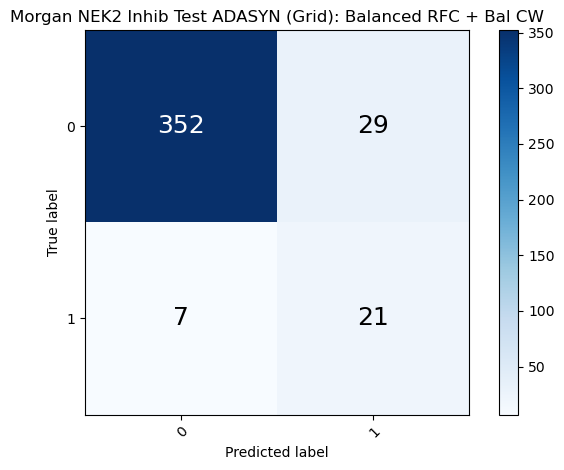

In [22]:
save_file4 = 'atom_nek2Morgan2inhib_BRFC_BCW_best.pkl'
# with open(save_file4, 'wb') as f:
#     pickle.dump(brfc_BCW_ADASYN_best['best_model'], f)
with open('../saved_models/'+save_file4, 'rb') as f: 
    brfc_BCW_best = pickle.load(f) 


grid_results4 = rf_results2(brfc_BCW_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results4['test_pred'], ['0','1'], title='Morgan NEK2 Inhib Test ADASYN (Grid): Balanced RFC + Bal CW')


In [ ]:
rf_basicbest
rf_basicBCWbest
brfc_bestADASYN
brfc_BCW_best

In [32]:
nek2inhib_morgan = {'default_RF':rf_basicbest,
                            'rf_bcw':rf_basicBCWbest,
                             'BRFC': brfc_bestADASYN,
                            'BRFC_bcw':brfc_BCW_best}

with open('nek2inhib_Morgan2GRIDmodels.pkl', 'wb') as f: 
    pickle.dump(nek2inhib_morgan, f)

In [34]:
grid_models = [rf_basicbest,
           rf_basicBCWbest,
            brfc_bestADASYN,
           brfc_BCW_best]
model_dictionaries = []
for i, model in enumerate(grid_models): 
    print(type(model))
    train_results = save_rf_results(model, train_x, train_y)
    test_results  = save_rf_results(model, test_x, test_y) 
    model_dict = {'model':model, 'train_results':train_results, 'test_results':test_results}
    model_dictionaries.append(model_dict) 

with open('nek2_inhib_Morgan_gridresults.pkl', 'wb') as f:
    pickle.dump(model_dictionaries, f)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'imblearn.ensemble._forest.BalancedRandomForestClassifier'>
<class 'imblearn.ensemble._forest.BalancedRandomForestClassifier'>


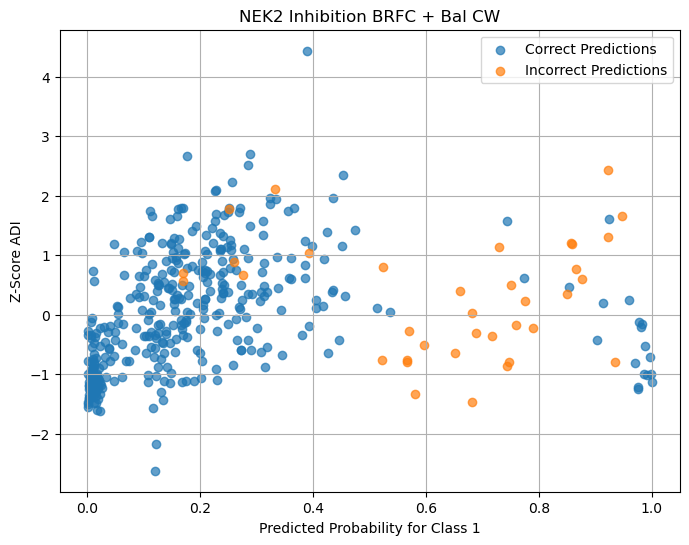

In [36]:
from scipy.spatial.distance import euclidean
from scipy.stats import zscore

def zscore_adi(train_x, test_x, k):

    mean_distances = []
    for compound in train_x:
        distances = [euclidean(compound, other) for other in train_x if not np.array_equal(compound, other)]
        mean_distances.append(np.mean(sorted(distances)[:k]))
    

    mean_distances = np.array(mean_distances)
    mean_distance_mean = np.mean(mean_distances)
    mean_distance_std = np.std(mean_distances)
    
    adi_zscores = []

    for unseen_compound in test_x:
        distances_to_neighbors = [euclidean(unseen_compound, other) for other in train_x]
        mean_distance_unseen = np.mean(sorted(distances_to_neighbors)[:k])
        z_score = (mean_distance_unseen - mean_distance_mean) / mean_distance_std
        adi_zscores.append(z_score)
    
    return adi_zscores




k = 5


probabilities0 = brfc_BCW_best.predict_proba(test_x)[:, 0]  
probabilities1 = brfc_BCW_best.predict_proba(test_x)[:, 1] 

adi_zscores = zscore_adi(train_x, test_x, k)
predictions = brfc_BCW_best.predict(test_x)
correct_pred = (predictions == test_y)

# plt.figure(figsize=(8, 6))
# plt.scatter(probabilities0, adi_zscores, label='UNDER NEK2 Bind class 0', alpha=0.7)
# plt.scatter(probabilities1, adi_zscores, label='UNDER NEK2 Bind class 1', alpha=0.7)
# plt.xlabel('Predicted Probability')
# plt.ylabel('Z-Score ADI')
# plt.title('Z-Score ADI vs Predicted Probabilities')
# plt.legend()
# plt.grid(True)
# plt.show()
adi_zscores = np.array(adi_zscores)

plt.figure(figsize=(8, 6))
plt.scatter(probabilities1[correct_pred], adi_zscores[correct_pred], label='Correct Predictions', alpha=0.7)
plt.scatter(probabilities1[~correct_pred], adi_zscores[~correct_pred], label='Incorrect Predictions',  alpha=0.7)
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Z-Score ADI')
plt.title('Morgan NEK2 Inhibition BRFC + Bal CW')
plt.legend()
plt.grid(True)
plt.show()

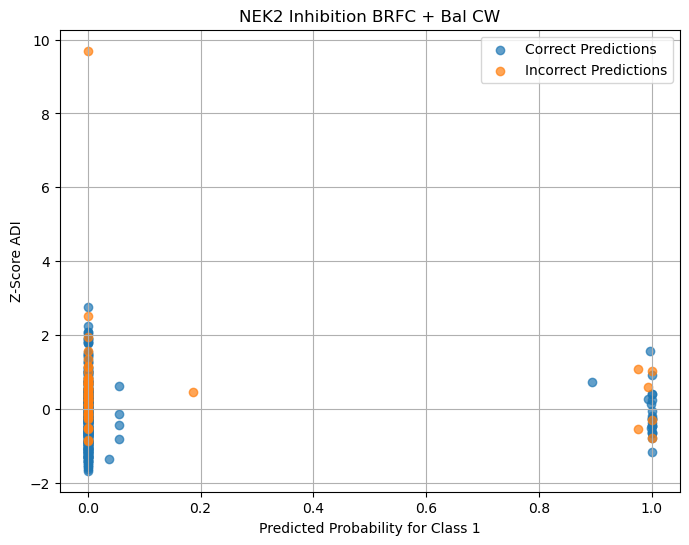

In [14]:
probabilities_bad0 = brfc_BCW_best.predict_proba(test_x)[:, 0]  
probabilities_bad1 = brfc_BCW_best.predict_proba(test_x)[:, 1] 

adi_zscores = zscore_adi(train_x, test_x, k)
predictions = brfc_BCW_best.predict(test_x)
correct_pred = (predictions == test_y)

# plt.figure(figsize=(8, 6))
# plt.scatter(probabilities0, adi_zscores, label='UNDER NEK2 Bind class 0', alpha=0.7)
# plt.scatter(probabilities1, adi_zscores, label='UNDER NEK2 Bind class 1', alpha=0.7)
# plt.xlabel('Predicted Probability')
# plt.ylabel('Z-Score ADI')
# plt.title('Z-Score ADI vs Predicted Probabilities')
# plt.legend()
# plt.grid(True)
# plt.show()
adi_zscores = np.array(adi_zscores)

plt.figure(figsize=(8, 6))
plt.scatter(probabilities1[correct_pred], adi_zscores[correct_pred], label='Correct Predictions', alpha=0.7)
plt.scatter(probabilities1[~correct_pred], adi_zscores[~correct_pred], label='Incorrect Predictions',  alpha=0.7)
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Z-Score ADI')
plt.title('NEK2 Inhibition BRFC + Bal CW')
plt.legend()
plt.grid(True)
plt.show()

TRAIN: accuracy: 0.902, precision: 0.410, recall: 1.000, specificity: 0.894
TEST: accuracy: 0.865, precision: 0.310, recall: 0.786, specificity: 0.871


<Figure size 600x400 with 0 Axes>

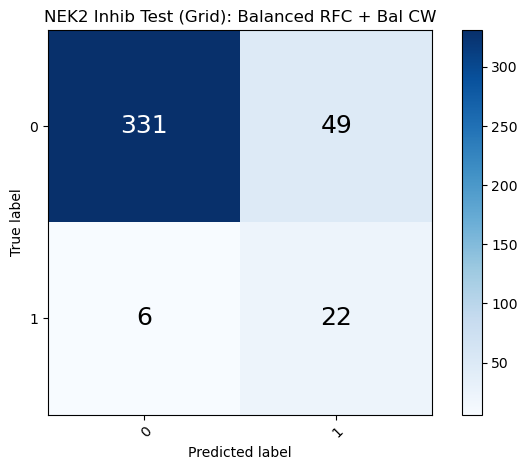

In [19]:
with open('saved_models/'+save_file4, 'rb') as f: 
    brfc_BCW_best = pickle.load(f) 
grid_results4 = rf_results2(brfc_BCW_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results4['test_pred'], ['0','1'], title='NEK2 Inhib Test (Grid): Balanced RFC + Bal CW')



In [24]:
for param, value in old_brfc_bcw.get_params().items():
    print(f'{param}: {value}')
print()
for param, value in brfc_BCW_best.get_params().items():
    print(f'{param}: {value}')


bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: entropy
max_depth: 200
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 200
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 4
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False


In [20]:
nek2inhib_models = {'default_RF':rf_basicbest, 'rf_bcw':rf_basicBCWbest,
                              'BRFC':brfc_best, 'BRFC_bcw':old_brfc_bcw}

# with open('nek2inhib_gridmodels.pkl', 'wb') as f:
#     pickle.dump(nek2inhib_models, f)


In [21]:
nek2inhib_models

{'default_RF': RandomForestClassifier(bootstrap=False, max_depth=20, max_features=None,
                        min_samples_leaf=5, n_estimators=1050),
 'rf_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced',
                        criterion='entropy', max_depth=220, max_features=None,
                        min_samples_leaf=2, min_samples_split=4),
 'BRFC': BalancedRandomForestClassifier(bootstrap=False, criterion='entropy',
                                max_depth=20, max_features=None,
                                min_samples_leaf=2, min_samples_split=4),
 'BRFC_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced',
                        criterion='entropy', max_depth=200, max_features=None,
                        min_samples_leaf=2)}

In [25]:
grid_models = [rf_basicbest, rf_basicBCWbest,brfc_best,old_brfc_bcw]
model_dictionaries = []
for i, model in enumerate(grid_models): 
    train_results = save_rf_results(model, train_x, train_y)
    test_results  = save_rf_results(model, test_x, test_y) 
    model_dict = {'model':model, 'train_results':train_results, 'test_results':test_results}
    model_dictionaries.append(model_dict) 

with open('nek2_inhib_original_results.pkl', 'wb') as f:
    pickle.dump(model_dictionaries, f)

In [27]:
with open('nek2_inhib_original_results.pkl', 'rb') as f: 
    results1= pickle.load(f)
recalls = [] 
for m, model in enumerate(results1): 
    recalls.append(model['test_results']['recall'])
# recalls

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 88.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 90.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


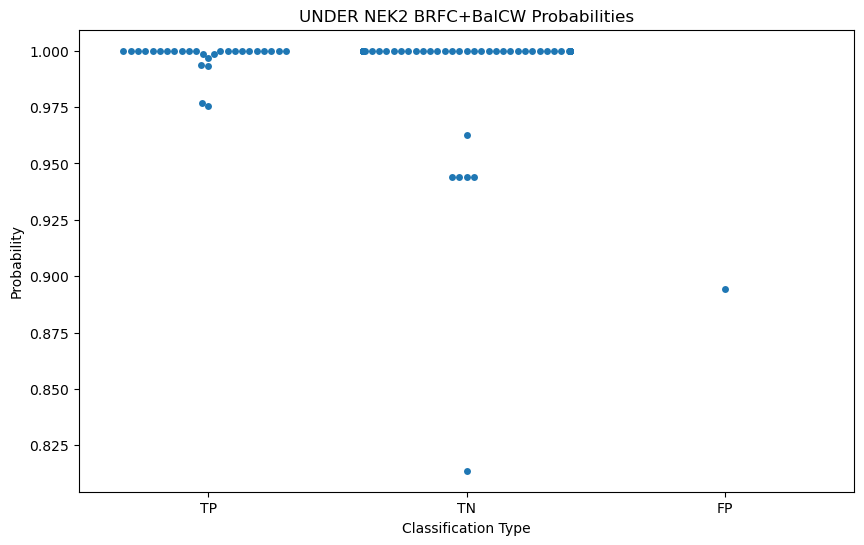

In [17]:
swarm_prob(old_brfc_bcw, test_x, test_y, 'UNDER NEK2 BRFC+BalCW Probabilities')